## 課題提出時（2018/12/16）の所感¶
https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics  
・こちらのカーネルをベースに動かしました。ミニバッチサイズ変更とBatchNormalization版を入れて比較してみましたが、あまり有益な情報は得られませんでした。  
・論文を読み込んで実装に落としたという感覚は今回のSprintでは掴めませんでした。この課題に対しては、早く論文を読める力などを上げて行くしかないと感じています。  
・Kerasのメソッドや作法を把握するのにも時間がかかりました。  
・AWSの利用方法はだいぶ習熟してきた感じがします。  

## 1.この課題の目的
・公開されている実装を動かす際のノウハウを得る  
・論文で読んだ手法を大規模なデータに適用する  
・過学習を抑制する手法を学ぶ  

【目的としないこと】  
・高い精度を出す  
以下の要件をすべて満たしていた場合、合格とします。  

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

## 2.進め方
・データセットを学習し推定（1日目〜2日目）  
・手法の説明を記述する。（2日目夜発表）  

## 3.過学習を抑制する
コーディング  
前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行う。  
https://www.kaggle.com/c/tgs-salt-identification-challenge  

過学習を抑制する工夫を行い、精度を改善させる。今回は高い精度であることよりも、過学習になっていないことを重視する。

## 説明
### 過学習の抑制  
過学習の抑制について説明せよ。以下の内容を含める。  
##### ・Batch Normalizationについて  
**【回答】**  
Batch Normと略記することもあります。2015年に提案された手法です。各層のアクティベーション（活性化関数の後の出力データ）の分布に適度な広がりを持たせることです。それにより、学習がスムーズに行える。  

メリットは次の点です。（※ゼロから作るDeepLearning P187より）  
・学習を速く進行させることができる（学習係数を大きくすることができる）  
・初期値にそれほど依存しない（初期値に対してそこまで神経質にならなくて良い）  
・過学習を抑制する（Dropoutなどの必要性を減らす）  

Batch Normalizationを組み入れる場所は、活性化関数の前です。畳み込みや全結合の後です。Batch Normを使用することで、重みの初期値にロバストになります。

##### ・その他過学習を抑制する手法について  
**【回答】**  
・Dropoutを組み入れる　　   
・データを増やす　　   
・Weight decayを組み入れる     
・ネットワーク構造をシンプルにする（重みパラメータを減らす）　　   
・スキップコネクションを組み入れる     
・ハイパーパラメータを調整する     
・Batch Normalizationを組み入れる      
・重みの初期値を変えてみる    


##### ・今回のsprintで実践したことについて  
**【回答】**  
ミニバッチの変更とBatch Normalizationを組み入れてみました。

### 転移学習とファインチューニング
転移学習とファインチューニングについて説明せよ。以下の内容を含める。

##### ・転移学習とファインチューニングの意味の違いについて  
**【回答】**  
・転移学習：既存の学習済モデル（出力層以外の部分）を、重みデータは変更せずに特徴量抽出機として利用する。  
・ファインチューニング：既存の学習済モデル（出力層以外の部分）を、重みデータを一部再学習して特徴量抽出機として利用する。  
いづれにしても、手元にあるデータセットが少ない場合において特に有効な手法です。

##### ・ImageNetによる事前学習モデルについて  
**【回答】**  
ImageNet（140万個のラベル付きの画像と1,000種類のクラス）の巨大なデータセットを使って学習した重みデータです。Kerasにはパッケージ化されております。  
・Xception  
・Inception V3  
・ResNet50  
・VGG16  
・VGG19  
・MobileNet  


##### ・事前学習モデルの選び方について  
**【回答】**  
VGG16がよく利用されているようです。理由はコンペの成績は１位ではないのですが、シンプルなCNNアーキテクチャーだからのようです。業務で事前学習モデルを利用する際の選び方ですが、業務で利用するネットワークモデルと近い物を選んだ方が良いと思います。（間違っておりましたらご指摘ください）

### Early Stopping
ディープラーニングを使用する際のエポックの扱い方について、Early Stoppingを中心に説明せよ。  
**【回答】**  
Early Stoppingにより、学習が進まなくなったタイミングで自動で終了するため、出来るだけ多いエポック数に設定しておいた方が良いと思います。この設定が短いと、エポック数の上限に達した場合、未学習になってしまうためです。


# Data Exploration
Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.
いくつかのデータを見てみましょう。 TGSは、検査によって非常に多様なデータを使用することを選択したことがわかります。 それは素晴らしいことであり、現時点では深遠な地球科学の問題に取り組んでいます。 1つのタイプの耐震モデルを構築し、それが一般化しているかどうかはわかりません。

In [43]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers.normalization import BatchNormalization

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [20]:
# パラメータをセットする
im_width = 128
im_height = 128
im_chan = 1

# ローカルPC
#path_train = "/Users/tsuneo/kaggle/tgs_solt/train/"
#path_test = "/Users/tsuneo/kaggle/tgs_solt/test/"

# aws
path_train = "/home/ubuntu/salt/train/"
path_test = "/home/ubuntu/salt/test/"


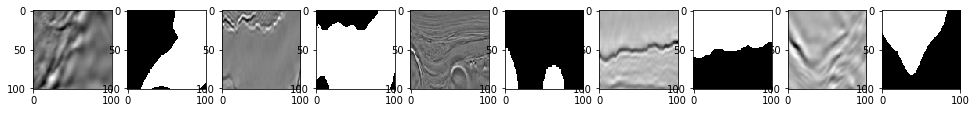

In [21]:
ids = ["4e86258646","5e09ef27a6","6cc7ba6c56","7af5b00299","9f0c9f3b90"]
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(path_train+"images/" + img_name + ".png")
    img_mask = load_img(path_train+"masks/" + img_name + ".png")
    
    plt.subplot(1, 2*(1+len(ids)), q*2-1)
    plt.imshow(img)
    plt.subplot(1, 2*(1+len(ids)), q*2)
    plt.imshow(img_mask)
plt.show()
    

We have many examples without salt, as you can see by the masks that are entirely dark. That's great, an algorithm we build will then know that patches exist entirely without salt. Talk about biasing your data.

We can draw heavily on other work, instead of regurgitating the geophysics work that has been done before. I mentioned that seismic is kind of like ultrasound. So I had a look at https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

Let's throw a Unet at our data. I am blatanly stealing from Ketil at this point. All credit goes to him and his nice code. First we'll need to get our data into a shape that works for U-Nets. That means, it should be a power of 2. Let's do it quick and dirty for now, but eventually, consider aliasing and all that fun.

完全に暗いマスクで見ることができるように、私たちは塩のない多くの例を持っています。 それは素晴らしいことです。私たちが構築するアルゴリズムは、パッチが完全に塩なしで存在することを知ります。 あなたのデータをバイアスすることについて話してください。

これまでに行われた地球物理学の研究を逆行させるのではなく、他の研究に重点を置くことができます。 地震は超音波のようなものだと言いました。 そこで私はhttps://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277を見ました。

私たちのデータにUnetを投げましょう。 私はこの時点で、Ketilからblatanly盗んでいます。 すべてのクレジットは彼と彼の素敵なコードに行きます。 まず、データをUネッツで動作する形にする必要があります。 それは2の威力でなければならないということを意味しています。今は素早く汚れてみましょう。でも、最終的にはエイリアシングとそのすべての楽しみを考慮してください。

In [22]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [23]:
print(len(train_ids),type(train_ids))
print(len(test_ids),type(test_ids))

4000 <class 'list'>
18000 <class 'list'>


In [24]:
train_ids[0:4]

['1c6f7aac78.png', '6d9be2f492.png', '104ce199d8.png', 'ea9dfe6f60.png']

In [25]:
print(len(train_ids), im_height, im_width, im_chan)
print(len(train_ids), im_height, im_width, 1)

4000 128 128 1
4000 128 128 1


In [26]:
# Get and resize train images and masks
# 「訓練」と「マスク」画像の取得と、サイズ変更

X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print("Getting and resizing train images and masks ....")
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    
    img_x = load_img(path + "/images/" + id_)
    img_y = load_img(path + "/masks/" + id_)
    
    x    = img_to_array(img_x)[:, :, 1]
    mask = img_to_array(img_y)[:, :, 1]
    
    X_train[n] = resize(x, (128,128,1),      mode="constant", preserve_range=True)
    Y_train[n] = resize(mask, (128, 128, 1), mode="constant", preserve_range=True)
    
print("Done!")

Getting and resizing train images and masks ....


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [27]:
print(X_train.shape, type(X_train))
print(Y_train.shape, type(Y_train))

(4000, 128, 128, 1) <class 'numpy.ndarray'>
(4000, 128, 128, 1) <class 'numpy.ndarray'>


<function matplotlib.pyplot.show(*args, **kw)>

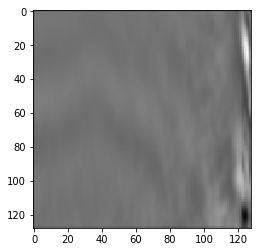

In [28]:
# Check if training data looks all right
# 訓練データが正しいか確認する
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix], X_train[ix], X_train[ix])))
plt.show


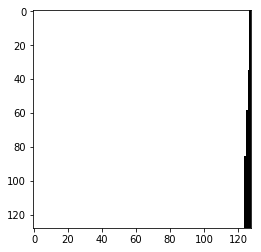

In [29]:
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

# Train Model
Our task, just like the segmentation task for nuclei, is evaluated on the mean IoU metric. This one isn't in keras, but obviously, we're stealing this one too from Ketil.

我々のタスクは、核のセグメンテーションタスクと同様に、平均IoUメトリックで評価されます。 これはケラではありませんが、明らかにKetilからもこれを盗んでいます。

In [30]:
# Define IoU metric
# IoUメトリックを定義する

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

This is the fun part. Building the sequential Model. The U-Net is basically looking like an Auto-Encoder with shortcuts.

We're also sprinkling in some earlystopping to prevent overfitting. If you're running this on kaggle, this is the point, you want to have GPU support.

これは楽しい部分です。 連続モデルの構築。 U-Netは、基本的にショートカット付きの自動エンコーダのように見えます。

私たちはまた、過度の詰まりを防ぐために早期停止の中に散らばっています。 あなたがkaggleでこれを実行している場合、これがポイントです。あなたはGPUをサポートしたいと思っています。

In [31]:
im_height, im_width,im_chan

(128, 128, 1)

In [32]:
# Build U-Net model
# Uネットモデルを構築する
def unet(im_height, im_width, im_chan):
    inputs = Input((im_height, im_width, im_chan))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    
    return model


model = unet(128, 128, 1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 8)  80          lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 128, 128, 8)  584         conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [33]:
# 作者の初期値のまま
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch8-epoch30.h5', verbose=1,save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 56s 16ms/step - loss: 0.5031 - mean_iou: 0.3745 - val_loss: 0.4103 - val_mean_iou: 0.3971

Epoch 00001: val_loss improved from inf to 0.41031, saving model to model-tgs-salt-batch8-epoch30.h5
Epoch 2/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3814 - mean_iou: 0.4327 - val_loss: 0.3034 - val_mean_iou: 0.4671

Epoch 00002: val_loss improved from 0.41031 to 0.30339, saving model to model-tgs-salt-batch8-epoch30.h5
Epoch 3/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3314 - mean_iou: 0.4943 - val_loss: 0.3054 - val_mean_iou: 0.5184

Epoch 00003: val_loss did not improve from 0.30339
Epoch 4/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3147 - mean_iou: 0.5375 - val_loss: 0.2752 - val_mean_iou: 0.5541

Epoch 00004: val_loss improved from 0.30339 to 0.27521, saving model to model-tgs-salt-batch8-epoch30.h5
Epoch 

学習

In [34]:
# バッチサイズを１００にしてみた。
model2 = unet(128, 128, 1)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch100-epoch30.h5', verbose=1,save_best_only=True)
results = model2.fit(X_train, Y_train, validation_split=0.1, batch_size=100, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 16s 4ms/step - loss: 0.6411 - mean_iou: 0.3580 - val_loss: 0.5859 - val_mean_iou: 0.3754

Epoch 00001: val_loss improved from inf to 0.58586, saving model to model-tgs-salt-batch100-epoch30.h5
Epoch 2/30
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5633 - mean_iou: 0.3748 - val_loss: 0.5564 - val_mean_iou: 0.3752

Epoch 00002: val_loss improved from 0.58586 to 0.55637, saving model to model-tgs-salt-batch100-epoch30.h5
Epoch 3/30
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5223 - mean_iou: 0.3751 - val_loss: 0.4995 - val_mean_iou: 0.3749

Epoch 00003: val_loss improved from 0.55637 to 0.49948, saving model to model-tgs-salt-batch100-epoch30.h5
Epoch 4/30
3600/3600 [==============================] - 10s 3ms/step - loss: 0.4669 - mean_iou: 0.3745 - val_loss: 0.4374 - val_mean_iou: 0.3785

Epoch 00004: val_loss improved from 0.49948 to 0.437

In [37]:
# バッチサイズを２００にしてみた。
model3 = unet(128, 128, 1)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch200-epoch30.h5', verbose=1,save_best_only=True)
results = model3.fit(X_train, Y_train, validation_split=0.1, batch_size=200, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 14s 4ms/step - loss: 0.6870 - mean_iou: 0.3548 - val_loss: 0.6738 - val_mean_iou: 0.3759

Epoch 00001: val_loss improved from inf to 0.67378, saving model to model-tgs-salt-batch200-epoch30.h5
Epoch 2/30
3600/3600 [==============================] - 9s 3ms/step - loss: 0.6086 - mean_iou: 0.3752 - val_loss: 0.5789 - val_mean_iou: 0.3750

Epoch 00002: val_loss improved from 0.67378 to 0.57888, saving model to model-tgs-salt-batch200-epoch30.h5
Epoch 3/30
3600/3600 [==============================] - 9s 3ms/step - loss: 0.5648 - mean_iou: 0.3745 - val_loss: 0.5750 - val_mean_iou: 0.3747

Epoch 00003: val_loss improved from 0.57888 to 0.57500, saving model to model-tgs-salt-batch200-epoch30.h5
Epoch 4/30
3600/3600 [==============================] - 9s 3ms/step - loss: 0.5425 - mean_iou: 0.3746 - val_loss: 0.5444 - val_mean_iou: 0.3746

Epoch 00004: val_loss improved from 0.57500 to 0.54443,

In [40]:
# バッチサイズを32にしてみた。
model4 = unet(128, 128, 1)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch32-epoch30.h5', verbose=1,save_best_only=True)
results = model4.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 20s 5ms/step - loss: 0.5676 - mean_iou: 0.3714 - val_loss: 0.5107 - val_mean_iou: 0.3747

Epoch 00001: val_loss improved from inf to 0.51068, saving model to model-tgs-salt-batch32-epoch30.h5
Epoch 2/30
3600/3600 [==============================] - 14s 4ms/step - loss: 0.4672 - mean_iou: 0.3730 - val_loss: 0.4369 - val_mean_iou: 0.3750

Epoch 00002: val_loss improved from 0.51068 to 0.43686, saving model to model-tgs-salt-batch32-epoch30.h5
Epoch 3/30
3600/3600 [==============================] - 14s 4ms/step - loss: 0.4418 - mean_iou: 0.3807 - val_loss: 0.3747 - val_mean_iou: 0.3918

Epoch 00003: val_loss improved from 0.43686 to 0.37472, saving model to model-tgs-salt-batch32-epoch30.h5
Epoch 4/30
3600/3600 [==============================] - 14s 4ms/step - loss: 0.3782 - mean_iou: 0.4116 - val_loss: 0.3659 - val_mean_iou: 0.4326

Epoch 00004: val_loss improved from 0.37472 to 0.36589,

In [44]:
# Build U-Net model
# Uネットモデルを構築する
# BatchNormalization版
def unet_batch(im_height, im_width, im_chan):
    inputs = Input((im_height, im_width, im_chan))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    
    return model

In [45]:
# 作者の初期値のまま
# BatchNormalization版
model5 = unet_batch(128, 128, 1)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch8-epoch30_batch.h5', verbose=1,save_best_only=True)
results = model5.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 30s 8ms/step - loss: 0.4527 - mean_iou: 0.5121 - val_loss: 0.4259 - val_mean_iou: 0.5720

Epoch 00001: val_loss improved from inf to 0.42587, saving model to model-tgs-salt-batch8-epoch30_batch.h5
Epoch 2/30
3600/3600 [==============================] - 23s 6ms/step - loss: 0.3179 - mean_iou: 0.5888 - val_loss: 0.3033 - val_mean_iou: 0.6040

Epoch 00002: val_loss improved from 0.42587 to 0.30327, saving model to model-tgs-salt-batch8-epoch30_batch.h5
Epoch 3/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.2778 - mean_iou: 0.6161 - val_loss: 0.2808 - val_mean_iou: 0.6282

Epoch 00003: val_loss improved from 0.30327 to 0.28084, saving model to model-tgs-salt-batch8-epoch30_batch.h5
Epoch 4/30
3600/3600 [==============================] - 22s 6ms/step - loss: 0.2587 - mean_iou: 0.6360 - val_loss: 0.2271 - val_mean_iou: 0.6458

Epoch 00004: val_loss improved from 0.28

In [46]:
# バッチサイズを１００にしてみた。
# BatchNormalization版
model6 = unet_batch(128, 128, 1)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch100-epoch30_batch.h5', verbose=1,save_best_only=True)
results = model6.fit(X_train, Y_train, validation_split=0.1, batch_size=100, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.5694 - mean_iou: 0.4467 - val_loss: 0.4190 - val_mean_iou: 0.5654

Epoch 00001: val_loss improved from inf to 0.41901, saving model to model-tgs-salt-batch100-epoch30_batch.h5
Epoch 2/30
3600/3600 [==============================] - 12s 3ms/step - loss: 0.3867 - mean_iou: 0.6128 - val_loss: 0.4033 - val_mean_iou: 0.6397

Epoch 00002: val_loss improved from 0.41901 to 0.40330, saving model to model-tgs-salt-batch100-epoch30_batch.h5
Epoch 3/30
3600/3600 [==============================] - 12s 3ms/step - loss: 0.3231 - mean_iou: 0.6598 - val_loss: 0.3300 - val_mean_iou: 0.6721

Epoch 00003: val_loss improved from 0.40330 to 0.33001, saving model to model-tgs-salt-batch100-epoch30_batch.h5
Epoch 4/30
3600/3600 [==============================] - 12s 3ms/step - loss: 0.2849 - mean_iou: 0.6824 - val_loss: 0.3338 - val_mean_iou: 0.6923

Epoch 00004: val_loss did not impr

In [47]:
# バッチサイズを2００にしてみた。
# BatchNormalization版
model7 = unet_batch(128, 128, 1)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch200-epoch30_batch.h5', verbose=1,save_best_only=True)
results = model7.fit(X_train, Y_train, validation_split=0.1, batch_size=200, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.6755 - mean_iou: 0.3853 - val_loss: 0.8190 - val_mean_iou: 0.4808

Epoch 00001: val_loss improved from inf to 0.81902, saving model to model-tgs-salt-batch200-epoch30_batch.h5
Epoch 2/30
3600/3600 [==============================] - 11s 3ms/step - loss: 0.4398 - mean_iou: 0.5288 - val_loss: 2.0690 - val_mean_iou: 0.5667

Epoch 00002: val_loss did not improve from 0.81902
Epoch 3/30
3600/3600 [==============================] - 11s 3ms/step - loss: 0.3487 - mean_iou: 0.5927 - val_loss: 0.6651 - val_mean_iou: 0.6151

Epoch 00003: val_loss improved from 0.81902 to 0.66505, saving model to model-tgs-salt-batch200-epoch30_batch.h5
Epoch 4/30
3600/3600 [==============================] - 11s 3ms/step - loss: 0.3119 - mean_iou: 0.6311 - val_loss: 0.5139 - val_mean_iou: 0.6443

Epoch 00004: val_loss improved from 0.66505 to 0.51392, saving model to model-tgs-salt-batch200-

In [48]:
# バッチサイズを32にしてみた。
# BatchNormalization版
model8 = unet_batch(128, 128, 1)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-batch32-epoch30_batch.h5', verbose=1,save_best_only=True)
results = model8.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 25s 7ms/step - loss: 0.5315 - mean_iou: 0.4485 - val_loss: 0.3386 - val_mean_iou: 0.5585

Epoch 00001: val_loss improved from inf to 0.33864, saving model to model-tgs-salt-batch32-epoch30_batch.h5
Epoch 2/30
3600/3600 [==============================] - 17s 5ms/step - loss: 0.3457 - mean_iou: 0.6075 - val_loss: 0.2924 - val_mean_iou: 0.6329

Epoch 00002: val_loss improved from 0.33864 to 0.29242, saving model to model-tgs-salt-batch32-epoch30_batch.h5
Epoch 3/30
3600/3600 [==============================] - 17s 5ms/step - loss: 0.2780 - mean_iou: 0.6495 - val_loss: 0.2647 - val_mean_iou: 0.6655

Epoch 00003: val_loss improved from 0.29242 to 0.26467, saving model to model-tgs-salt-batch32-epoch30_batch.h5
Epoch 4/30
3600/3600 [==============================] - 17s 5ms/step - loss: 0.2514 - mean_iou: 0.6757 - val_loss: 0.3259 - val_mean_iou: 0.6846

Epoch 00004: val_loss did not improve

## サマリ
ミニバッチ８が妥当だと思いました。BatchNormalizationを組み込んで見ましたが、ミニバッチ32でloss最小値0.0708を記録しました。ただ、val_lossがミニバッチ８に比べて精度が出ていないのでダメだと思います。

<BatchNormalizationなし版>  
ミニバッチ：8    loss: 0.1305 - mean_iou: 0.7450 - val_loss: 0.1731 - val_mean_iou: 0.7470  
ミニバッチ：32   loss: 0.1350 - mean_iou: 0.6977 - val_loss: 0.1909 - val_mean_iou: 0.7003  
ミニバッチ：100  loss: 0.1436 - mean_iou: 0.6870 - val_loss: 0.1784 - val_mean_iou: 0.6893  
ミニバッチ：200  loss: 0.2124 - mean_iou: 0.5994 - val_loss: 0.2273 - val_mean_iou: 0.6019  

<BatchNormalizationあり版>  
ミニバッチ：8    loss: 0.1503 - mean_iou: 0.7504 - val_loss: 0.1656 - val_mean_iou: 0.7526  
ミニバッチ：32   loss: 0.0708 - mean_iou: 0.8023 - val_loss: 0.1718 - val_mean_iou: 0.8045  
ミニバッチ：100  loss: 0.1306 - mean_iou: 0.7757 - val_loss: 0.3338 - val_mean_iou: 0.7780  
ミニバッチ：200  loss: 0.1328 - mean_iou: 0.7672 - val_loss: 0.2281 - val_mean_iou: 0.7699  


# Test Data
First we'll get the test data. This takes a while, it's 18000 samples.

まず、テストデータを取得します。 これにはしばらく時間がかかります.18000サンプルです。

In [50]:
# Get and resize test images
# テストイメージの取得とサイズ変更
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ...')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:, :, 1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x
    
print('Done!!!!!!')

Getting and resizing test images ...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!!!!!!


In [51]:
# batch8  BatchNormalizationなし版
# Predict on train, val and test
# 訓練データ、検証データ、テストデータで予測する
model1       = load_model('model-tgs-salt-batch8-epoch30.h5', custom_objects={'mean_iou': mean_iou})
preds_train1 = model1.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val1 = model1.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test1  = model1.predict(X_test, verbose=1)

# Threshold predicitons
# 閾値予測
preds_train_t1 = (preds_train1 > 0.5).astype(np.uint8)
preds_val_t1 = (preds_val1 > 0.5).astype(np.uint8)
preds_test_t1 = (preds_test1 > 0.5).astype(np.uint8)

18000/18000 [==============================] - 16s 883us/step


In [52]:
# batch8  BatchNormalizationあり版
# Predict on train, val and test
# 訓練データ、検証データ、テストデータで予測する
model2       = load_model('model-tgs-salt-batch8-epoch30_batch.h5', custom_objects={'mean_iou': mean_iou})
preds_train2 = model2.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val2 = model2.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test2  = model2.predict(X_test, verbose=1)

# Threshold predicitons
# 閾値予測
preds_train_t2 = (preds_train2 > 0.5).astype(np.uint8)
preds_val_t2 = (preds_val2 > 0.5).astype(np.uint8)
preds_test_t2 = (preds_test2 > 0.5).astype(np.uint8)

18000/18000 [==============================] - 18s 978us/step


In [57]:
%autosave 0

Autosave disabled


We'll look at it again, just to be sure.

私たちはそれをもう一度見て、確かにします。

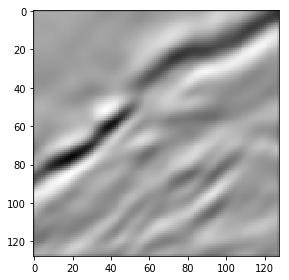

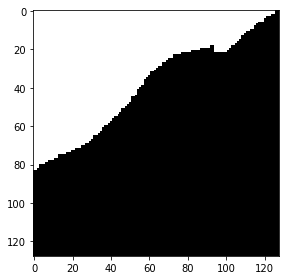

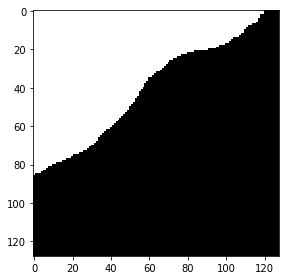

In [125]:
# perform a sanity check on some random traiining samples
# いくつかのランダムトレーニングサンプルでサニティチェックを実行する

ix = random.randint(0, len(preds_train_t1))
imshow(np.dstack((X_train[ix], X_train[ix], X_train[ix])))
plt.show()

tmp1 = np.squeeze(Y_train[ix]).astype(np.float32)
imshow(np.dstack((tmp1, tmp1, tmp1)))
plt.show()

tmp2 = np.squeeze(preds_train_t1[ix]).astype(np.float32)
imshow(np.dstack((tmp2, tmp2, tmp2)))
plt.show()

fig.tight_layout()

## テストデータの予測結果もちゃんと表示されていました

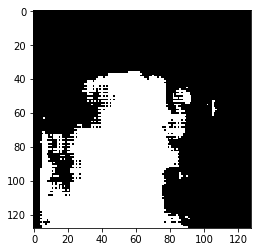

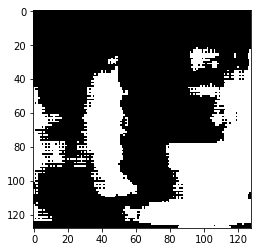

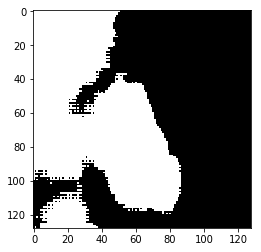

In [121]:
tmp = np.squeeze(preds_test_t1[0]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

tmp = np.squeeze(preds_test_t1[4]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

tmp = np.squeeze(preds_test_t1[5]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

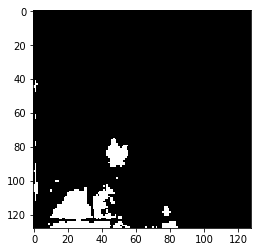

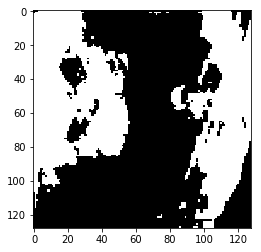

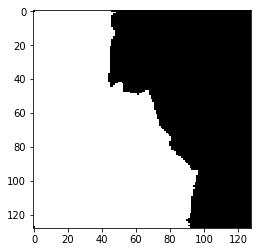

In [117]:
tmp = np.squeeze(preds_test_t2[0]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

tmp = np.squeeze(preds_test_t2[4]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

tmp = np.squeeze(preds_test_t2[5]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

# Prepare Submission
We need to prepare the submission. A nice CSV with predictions. All of this is one to one from Ketil and does not differ from any of the other segmentation tasks. Check them out to improve on this.

我々は提出を準備する必要があります。 予期した素晴らしいCSV。 これらはすべてKetilの1対1であり、他のセグメンテーションタスクとは異ならない。 これを改善するためにそれらをチェックしてください。

In [21]:
def RLenc(img, order='F', format=True):
    
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    # list of run lengths
    runs = []
    
    r = 0
    
    pos = 1
    
    for c in bytes:
        if (c ==0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1
            
    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0
        
    if format:
        z = ''
        
        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i, fn in tqdm_notebook(enumerate(test_ids))}
